In [3]:
#!/usr/bin/env python
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray

In [12]:
class testprocessor(processor.ProcessorABC):
    def __init__(self):
        


        self._accumulator = processor.dict_accumulator({ 
            'mT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('mT','Transverse Mass',100,0,600)),
            
            'ele_pt': hist.Hist(
                'Events',
                hist.Cat('dataset', 'dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pT', 'Leading $e_{pT} GeV', 10,0,200))
        }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
 

        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()


        dataset = events.metadata['dataset']

        #creating objects
        Muon     = events.Muon
        Electron = events.Electron
        Photon   = events.Photon
        Met      = events.MET
        Jet      = events.Jet
        
        # Met pT > 100
        
        Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        TightMet =  ~(Met.pt==np.nan)
        TightMet = Met[Met.pt >= 100]
        
        # no loose photon LoosePhoton.counts == 0
        Electron['T'] = TVector2Array.from_polar(Electron.pt, Electron.phi)
        Muon['T'] = TVector2Array.from_polar(Muon.pt, Muon.phi)
        Electron['p4'] = TLorentzVectorArray.from_ptetaphim(Electron.pt, Electron.eta, Electron.phi, Electron.mass)
        Muon['p4'] = TLorentzVectorArray.from_ptetaphim(Muon.pt, Muon.eta, Muon.phi, Muon.mass)
        
        LoosePhoSel = ~(Photon.pt==np.nan)#just a complicated way to initialize a jagged array with the needed shape to True
        LoosePhoSel = (Photon.pt>15) & ~((abs(Photon.eta) > 1.4442) & (abs(Photon.eta) < 1.566)) & (abs(Photon.eta) < 2.5) & (abs(Photon.cutBasedBitmap &1) == 1)

        TightPhoSel = ~(Photon.pt==np.nan)  
        TightPhoSel = (Photon.pt>230)&((Photon.cutBasedBitmap&2)==2)

        LoosePhoton = Photon[LoosePhoSel] 
        TightPhoton = Photon[TightPhoSel]
        
        
        
        #if lepton is electron then 
        # 1 tight e and o loosemu
        
        # TightElectron.counts == 1 & LooseMuon.counts== 0
        
        TightEleSel = ~(Electron.pt==np.nan)
        TightEleSel = ((Electron.pt>40)&(abs(Electron.eta)<1.4442)&(abs(Electron.dxy)<0.05)&(abs(Electron.dz)<0.1)&(Electron.cutBased==4)) | ((Electron.pt>40)&(abs(Electron.eta)>1.5660)&(abs(Electron.eta)<2.5)&(abs(Electron.dxy)<0.1)&(abs(Electron.dz)<0.2)&(Electron.cutBased==4)) # Trigger: HLT_Ele32_WPTight_Gsf_v
        TightElectron = Electron[TightEleSel]

        LooseMuonSel = ~(Muon.pt==np.nan)
        LooseMuonSel = (Muon.pt>15)&(abs(Muon.eta)<2.4)&(Muon.looseId>0)&(Muon.pfRelIso04_all<0.25)
        LooseMuon = Muon[LooseMuonSel]
        
        #if lepton is muon then 
        # 1 tight mo and o loose electron
        
        # TightMuon.counts == 1 & LooseElectron.counts== 0
        
        TightMuSel = ~(Muon.pt==np.nan)
        TightMuSel = (Muon.pt>30)&(abs(Muon.eta)<2.4)&(Muon.tightId)&(Muon.pfRelIso04_all<0.15)

        TightMuon = Muon[TightMuSel]

        LooseEleSel = ~(Electron.pt==np.nan)
        LooseEleSel = ((Electron.pt>10)&(abs(Electron.eta)<1.4442)&(abs(Electron.dxy)<0.05)&(abs(Electron.dz)<0.1)&(Electron.cutBased>=1)) | ((Electron.pt>10)&(abs(Electron.eta)>1.5660)&(abs(Electron.eta)<2.5)&(abs(Electron.dxy)<0.1)&(abs(Electron.dz)<0.2)&(Electron.cutBased>=1))
        LooseElectron  = Electron[LooseEleSel]
        
        # calculate delta phi( leading ak4jet, met) > 1.5
        
        Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
        Jet['p4'] = TLorentzVectorArray.from_ptetaphim(Jet.pt, Jet.eta, Jet.phi, Jet.mass)
        LeadingJet = Jet[Jet.pt.argmax()]
        
        Delta_Phi_Met_LJ = (Met['T'].delta_phi(LeadingJet['T'].sum()) > 1.5)
            
        LeadingMu = Muon[Muon.pt.argmax()]
        LeadingMu = LeadingMu[(LeadingMu.pt>30)&(abs(LeadingMu.eta)<2.4)&(LeadingMu.tightId)&(LeadingMu.pfRelIso04_all<0.15)]
        LeadingEle = Electron[Electron.pt.argmax()]
        LeadingEle = LeadingEle[((LeadingEle.pt>40)&(abs(LeadingEle.eta)<1.4442)&(abs(LeadingEle.dxy)<0.05)&(abs(LeadingEle.dz)<0.1)&(LeadingEle.cutBased==4)) | ((LeadingEle.pt>40)&(abs(LeadingEle.eta)>1.5660)&(abs(LeadingEle.eta)<2.5)&(abs(LeadingEle.dxy)<0.1)&(abs(LeadingEle.dz)<0.2)&(LeadingEle.cutBased==4))]

            
        # *******calculate deltaR( leading ak4jet, e/mu) < 3.4 *****
        LJ_Ele        = LeadingJet['p4'].cross(TightElectron['p4'])
        DeltaR_LJ_Ele = LJ_Ele.i0.delta_r(LJ_Ele.i1)
        DeltaR_LJ_Ele_mask = (DeltaR_LJ_Ele<3.4).any()
        
        LJ_Mu = LeadingJet['p4'].cross(TightMuon['p4'])
        DeltaR_LJ_Mu = LJ_Mu.i0.delta_r(LJ_Mu.i1)
        DeltaR_LJ_Mu_mask = (DeltaR_LJ_Mu<3.4).any()
        
        #******** Triggers ***********
        
        #mask 4: ele triggers for e events
        EleTrigger = ['Ele32_WPTight_Gsf','Ele115_CaloIdVT_GsfTrkIdT','Photon200'] 
                                 
        
                # mask 5 : mu triggers for µ events
        MuTrigger = ['IsoMu24',
                    'Mu50',
                    'OldMu100',
                    'TkMu100']   
        # Photon trigger
        PhoTrigger = ['Photon200'] 
                           
        
        # met trigger
        MetTrigger = ['PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60','PFMETNoMu120_PFMHTNoMu120_IDTight'] 
        
        # ****** to add event selection in coffea ********
        
        selection = processor.PackedSelection()
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MetTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('met_triggers', triggers)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in EleTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('ele_triggers', triggers)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MuTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('mu_triggers', triggers)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in PhoTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('pho_triggers', triggers)
        
        selection.add('Delta_Phi_Met_LJ', Delta_Phi_Met_LJ)
        selection.add('DeltaR_LJ_mask', (DeltaR_LJ_Ele_mask | DeltaR_LJ_Mu_mask))
 #       selection.add('DeltaR_LJ_Mu_mask', DeltaR_LJ_Mu_mask)
        selection.add('TightMet', (Met.pt >= 100))
        selection.add('TightElectronLooseMuon', 
                      (TightElectron.counts == 1) & (LooseMuon.counts== 0))
        selection.add('TightMuonLooseElectron', 
                      (TightMuon.counts == 1) & (LooseElectron.counts== 0))        
        
        GeneralSelection = selection.all(*('met_triggers',
                                          'ele_triggers',
                                          'mu_triggers',
                                          'pho_triggers',
                                          'Delta_Phi_Met_LJ',
                                          'DeltaR_LJ_mask',
                                          'TightMet',
                                          'TightElectronLooseMuon',
                                          'TightMuonLooseElectron'))
        
        #******* Calculating transverse mass *****
        
        mT = {
            'wecr'  : np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum())))),
            'tecr'  : np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum())))),
            'wmcr'  : np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum())))),
            'tmcr'  : np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum())))) 
        }  
        
        for region, mt in mT.items():
            if region ==  'wecr':
                GeneralSelection = (GeneralSelection & DeltaR_LJ_Ele_mask)
            elif region ==  'tecr':
                GeneralSelection = (GeneralSelection & DeltaR_LJ_Ele_mask)
            elif region == 'wmcr':
                GeneralSelection = (GeneralSelection & DeltaR_LJ_Mu_mask)
            elif region == 'wmcr':
                GeneralSelection = (GeneralSelection & DeltaR_LJ_Mu_mask)

            output['mT'].fill(dataset='dataset',
                         region=region,
                             mT=mt[GeneralSelection].flatten() )
        for region,_ in mT.items():
            output['ele_pt'].fill(dataset='dataset',
                                 region = region,
                                 pt= TightElectron[TightElectron.counts==1].pt.flatten())
        
        return output   
    def postprocess(self, accumulator):
        return accumulator

In [13]:
fileset = {'EGamma':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5077.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5078.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5079.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5080.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5081.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5082.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5083.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5084.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5085.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5086.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5087.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5088.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5089.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5090.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5091.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5092.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5093.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5094.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5095.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5096.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5097.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5098.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5099.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5100.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5101.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5102.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5103.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5104.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5105.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5106.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5107.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5108.root"
        ]}
#Run Coffea code using uproot
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=testprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )

ValueError: Not all axes specified for <Hist (dataset,region,pT) instance at 0x7fe0b4096a20>.  Missing: pT

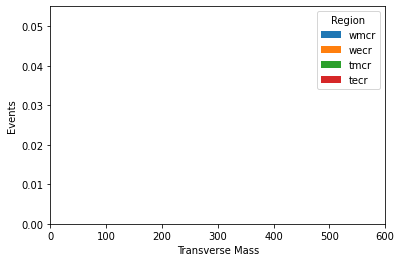

In [55]:
hist.plot1d(output['mT'].integrate('dataset'),overlay='region', stack=True)